In [2]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys
import matplotlib.pyplot as plt

In [3]:
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import time
import glob                                                                                                      
import datetime
from scipy.optimize import minimize
import sys

from fun_floodestimate import FloodHeight
from fun_floodestimate import FloodHeightWall
from fun_floodestimate import FloodTravelSectGroup
from fun_floodestimate import SurfaceVolFunc
from fun_damagecost import damage

from fun_objective_loop_manywalls import objective
#from fun_objective_loop import constraint1
#from fun_objective_loop import constraint2
#from fun_objective_loop import constraint3

#input_name = sys.argv[1]
output_name = sys.argv[1]

#x = np.loadtxt(input_name)

#ws = int(sys.argv[1])
#we = int(sys.argv[2])
#wh = float(sys.argv[3])
#wall_year = int(sys.argv[4])
#fname = sys.argv[5]

# setup
# Surface Volume Input
ndiv18 = 18
sections = [10,11,5,12,1,13,16,4,17,15,3,14,0,9,8,7,2,6]
files = glob.glob('NewSurfaceVolumeCombined/LMN_div18_*.csv') 
groupcsvfiles = glob.glob('NewSurfaceVolumeGrouped/LMN_div18_*.csv') 
H = np.append(np.linspace(0,3,13),np.linspace(3.5,7,8))

SVfg1 = np.zeros([ndiv18,2]);  SVfg2 = np.zeros([ndiv18,2]);  SVfg3 = np.zeros([ndiv18,2]);  SVfg4 = np.zeros([ndiv18,2])
SVfg5 = np.zeros([ndiv18,2]);  SVfg6 = np.zeros([ndiv18,2]);  SVfg7 = np.zeros([ndiv18,2]);  SVfg8 = np.zeros([ndiv18,2])
SVfg9 = np.zeros([ndiv18,2]);  SVfg10 = np.zeros([ndiv18,2]); SVfg11 = np.zeros([ndiv18,2]); SVfg12 = np.zeros([ndiv18,2])
SVfg13 = np.zeros([ndiv18,2]); SVfg14 = np.zeros([ndiv18,2]); SVfg15 = np.zeros([ndiv18,2]); SVfg16 = np.zeros([ndiv18,2])
SVfg17 = np.zeros([ndiv18,2]); SVfg18 = np.zeros([ndiv18,2]); SVfg19 = np.zeros([ndiv18,2]); SVfg20= np.zeros([ndiv18,2])

i = 0
for f in groupcsvfiles:
    surfaceVg = pd.read_csv(f)["volume"]
    SVfg1[i,:],SVfg2[i,:],SVfg3[i,:],SVfg4[i,:],SVfg5[i,:],SVfg6[i,:],SVfg7[i,:],SVfg8[i,:],SVfg9[i,:],SVfg10[i,:],SVfg11[i,:],SVfg12[i,:],SVfg13[i,:],SVfg14[i,:],SVfg15[i,:],SVfg16[i,:],SVfg17[i,:],SVfg18[i,:],SVfg19[i,:],SVfg20[i,:] = SurfaceVolFunc(surfaceVg,H)
    i = i + 1 


SVf1 = np.zeros([ndiv18,2]);  SVf2 = np.zeros([ndiv18,2]);  SVf3 = np.zeros([ndiv18,2]);  SVf4 = np.zeros([ndiv18,2])
SVf5 = np.zeros([ndiv18,2]);  SVf6 = np.zeros([ndiv18,2]);  SVf7 = np.zeros([ndiv18,2]);  SVf8 = np.zeros([ndiv18,2])
SVf9 = np.zeros([ndiv18,2]);  SVf10 = np.zeros([ndiv18,2]); SVf11 = np.zeros([ndiv18,2]); SVf12 = np.zeros([ndiv18,2])
SVf13 = np.zeros([ndiv18,2]); SVf14 = np.zeros([ndiv18,2]); SVf15 = np.zeros([ndiv18,2]); SVf16 = np.zeros([ndiv18,2])
SVf17 = np.zeros([ndiv18,2]); SVf18 = np.zeros([ndiv18,2]); SVf19 = np.zeros([ndiv18,2]); SVf20= np.zeros([ndiv18,2])

SV_all = []
i = 0
for f in files:
    surfaceV_height = pd.read_csv(f)
    surfaceV = surfaceV_height["volume"]
    SV_all = np.append(SV_all,surfaceV)
    SVf1[i,:],SVf2[i,:],SVf3[i,:],SVf4[i,:],SVf5[i,:],SVf6[i,:],SVf7[i,:],SVf8[i,:],SVf9[i,:],SVf10[i,:],SVf11[i,:],SVf12[i,:],SVf13[i,:],SVf14[i,:],SVf15[i,:],SVf16[i,:],SVf17[i,:],SVf18[i,:],SVf19[i,:],SVf20[i,:] = SurfaceVolFunc(surfaceV,H)
    i = i+1
SV_all = SV_all.reshape(18,21)

roughness = pd.read_csv("Roughness.csv")["Roughness"]
slope = pd.read_csv("LMN_Slope.csv")["Slope"]

# Setup - Division Connectivities
sect3 = np.zeros([len(sections)-6,7])
k = 3
for i in sections[3:-3]:
    sect3[k-3] = [sections[k-3],sections[k-2],sections[k-1],i,sections[k+1],sections[k+2],sections[k+3]]
    k = k + 1

sect0  = [sections[0],sections[1],sections[2],sections[3]] 
sect1  = [sections[0],sections[1],sections[2],sections[3],sections[4]]
sect2  = [sections[0],sections[1],sections[2],sections[3],sections[4],sections[5]]

sect_3 = [sections[-6],sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_2 = [sections[-5],sections[-4],sections[-3],sections[-2],sections[-1]]
sect_1 = [sections[-4],sections[-3],sections[-2],sections[-1]]

# initial value
total_cost = 75*10**9 # total cost without any protective measure
cost_opt   = total_cost
x_opt 	   = [0,2040,0,0]

def objective2(h):
    
    w0 = np.ones(20)*h[0]
    w1 = np.ones(20)*h[1]
    w2 = np.ones(20)*h[2]
    w3 = np.ones(20)*h[3]
    w4 = np.ones(20)*h[4]
    w5 = np.ones(20)*h[5]
    w6 = np.ones(20)*h[6]
    w7 = np.ones(23)*h[7]

    x = np.concatenate((w0,w1,w2,w3,w4,w5,w5,w7))
    
    total_cost_new, wall_cost = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    print(total_cost_new)
    return total_cost_new

def objective3(x_input):
    x = np.zeros(163)
    ws = int(max(x_input[0],0))
    we = int(min(x_input[1],162))
    wh = x_input[2]
    x[ws:we] = np.ones(we-ws)*wh
    print(x_input)
    
    total_cost_new, wall_cost = objective(x,SVf1,SVf2,SVf3,SVf4,SVf5,SVf6,SVf7,SVf8,SVf9,SVf10,SVf11,SVf12,SVf13,SVf14,SVf15,SVf16,SVf17,SVf18,SVf19,SVf20,
                                            SVfg1,SVfg2,SVfg3,SVfg4,SVfg5,SVfg6,SVfg7,SVfg8,SVfg9,SVfg10,SVfg11,SVfg12,SVfg13,SVfg14,SVfg15,SVfg16,SVfg17,SVfg18,SVfg19,SVfg20,
                                            SV_all,roughness,slope,sect0,sect1,sect2,sect3,sect_1,sect_2,sect_3,numiter=1)
    return total_cost_new

cons3 = [{'type': 'ineq', 'fun': lambda x:  x[1] - x[0]},
        {'type': 'ineq', 'fun': lambda x: x[0]},
        {'type': 'ineq', 'fun': lambda x: 162-x[1]},
        {'type': 'ineq', 'fun': lambda x: x[2]},
        {'type': 'ineq', 'fun': lambda x: 5.0-x[2]}]





C:\Users\pdine\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Nelder Mead

In [2]:
start_time = time.time()

#for ws in np.linspace(0,163,16):
#	for we in np.linspace(ws+10.866,163,int((163-(ws+10.866))/11)):
#		for wh in np.linspace(0.1,5,10):

#wall_init = [40.,60.,1.0]
heights_init = np.ones(8)*2
x_opt = scipy.optimize.minimize(objective2, heights_init, method='Nelder-Mead', tol = 10.0e6, options = {'disp': True, 'return_all': True})
print(x_opt)           


#if total_cost_new < total_cost:
#	total_cost  = total_cost_new
#	cost_opt 	= np.append(cost_opt,total_cost_new)
#	x_opt	  	= np.concatenate((x_opt,x))

elapsed_time = time.time() - start_time
print("Elapsed Time: ",elapsed_time, "sec")

#print('Optimal Variables:',x)
#print('Corresponding Cost:',total_cost_new)

#f = open(str(ws)+'-'+str(we) + '-' + str(wh),'w')
f = open("manywalls_runs\\"+output_name, 'w')
#f.write(str(input_name))
#f.write(str(total_cost_new))
#f.write(str(wall_cost))
f.write(str(heights_init))
f.write(str(x_opt))
#f.write(str(ws)+'\n'+str(we) + '\n' + str(wh) +'\n' +str(total_cost_new)+'\n')
#f.write(str(wall_cost))

0
2424580077.742787
0
2402670844.208201
0
2434418910.1450977
0
2119675730.5227022
0
2434422477.742787
0
2434422477.742787
0
2444264877.742787
0
2424580077.742787
0
2435898837.742787
0
2426101073.3145633
0
2206422131.946311
0
2215296108.9428205
0
2161301299.241634
0
2099926009.672359
0
2096869937.7217948
0
2166757108.7939706
0
1990378093.3976943
0
1880581250.8549175
0
1919414832.9881442
0
1972299278.54323
0
1865897699.8750446
0
1923177877.2340717
0
1865778794.7577274
0
1950782378.059563
0
1919300079.9818072
0
1949145603.9733286
0
2047983841.3422987
0
1947404694.285205
0
1964936267.409772
0
1960753598.8363051
0
2056613348.165797
0
1917516025.1647134
0
1968231346.6343842
0
1926445290.6980584
0
1929145215.1250641
0
2154054726.2796035
0
1923178037.9121428
0
1940925389.8934968
0
1884210266.105033
0
1869972175.706218
0
1984869880.5256183
0
1870036906.0674627
0
1871996151.9323046
0
1934142735.4802458
0
1991107708.8929446
0
1875717141.8403423
0
1877448104.6818042
0
1867937236.9273856
0
18691357

4999

#### Random starts

In [28]:


#for ws in np.linspace(0,163,16):
#	for we in np.linspace(ws+10.866,163,int((163-(ws+10.866))/11)):
#		for wh in np.linspace(0.1,5,10):

#wall_init = [40.,60.,1.0]
NUMINITS = 10
init_list = []
x_opt_list = []
for init_i in range(NUMINITS):
    start_time = time.time()
    heights_init = np.random.uniform(low=0.0, high=5.0, size=8)
    init_list.append(heights_init.copy())
    x_opt = scipy.optimize.minimize(objective2, heights_init, method='Nelder-Mead', tol = 10.0e6, options = {'disp': True, 'return_all': True})
    x_opt_list.append(x_opt)
    print(x_opt)    
    elapsed_time = time.time() - start_time
    print("Elapsed Time: ",elapsed_time, "sec")


#if total_cost_new < total_cost:
#	total_cost  = total_cost_new
#	cost_opt 	= np.append(cost_opt,total_cost_new)
#	x_opt	  	= np.concatenate((x_opt,x))



#print('Optimal Variables:',x)
#print('Corresponding Cost:',total_cost_new)

#f = open(str(ws)+'-'+str(we) + '-' + str(wh),'w')
f = open("manywalls_runs\\"+output_name, 'w')
#f.write(str(input_name))
#f.write(str(total_cost_new))
#f.write(str(wall_cost))
f.write(str(heights_init))
f.write(str(x_opt))
#f.write(str(ws)+'\n'+str(we) + '\n' + str(wh) +'\n' +str(total_cost_new)+'\n')
#f.write(str(wall_cost))

0
3352665919.4220233
0
3373760009.1125093
0
3373922708.3825283
0
3373799683.68831
0
3368357474.328615
0
3372812561.0542555
0
3399987454.6415577
0
3352665919.4220233
0
3373654840.7174873
0
3335422324.390379
0
3303139759.2647905
0
3343791333.3699746
0
3336412270.484608
0
3327115010.403435
0
3315585221.219943
0
3302120665.9245977
0
3266774718.35977
0
3281180063.6580257
0
3279000154.623619
0
3260583713.424018
0
3214542610.425017
0
3237146118.739827
0
3219708643.6889987
0
3202154312.091563
0
3139673962.935627
0
3169706286.703976
0
3148793380.518925
0
3137656405.340914
0
3065894576.182358
0
3086559919.7650046
0
3053731656.3801637
0
2947210125.3903604
0
3010876257.662739
0
2976105636.2070026
0
2921662425.916482
0
2871781637.2864633
0
2868647506.21594
0
2908739759.442038
0
2980551802.2720423
0
2988153672.014167
0
3342273521.5284495
0
2993851933.8561683
0
3093637186.3879657
0
2979016596.919459
0
2990685483.0314684
0
3172026623.046519
0
2926728054.9979334
0
2994095287.9481807
0
3008536589.322086

4068747093.989183
0
4087693639.9995227
0
4061248278.4248915
0
3821356198.287007
0
4077473894.8199267
0
4091505804.317295
0
4109004872.2305098
0
4068747093.989183
0
4092472011.693254
0
3935995993.017382
0
3918031270.6084795
0
3886556547.0664787
0
3892208229.3622775
0
3860486279.169994
0
3810952951.171825
0
3651986957.466268
0
3757559226.9834795
0
3531808538.6914177
0
3543503780.048072
0
3566404691.631291
0
3443846868.111325
0
3398448911.445655
0
3419001937.1628976
0
3458723638.1810627
0
3461078516.4533615
0
3377343738.4076467
0
3256077683.131612
0
3432910772.5626774
0
3421091296.387299
0
3363092550.822734
0
3346117460.310129
0
3420430624.8573885
0
3358817803.199137
0
3322335982.2443137
0
3276449357.6258626
0
3417974479.2485256
0
3067178390.7231054
0
2727678671.02307
0
3084345431.185211
0
2763433076.579527
0
2773641162.527522
0
2785138122.101443
0
2727194756.02921
0
2559119678.6288114
0
2593950401.6154504
0
2566252187.9618974
0
2586221538.3368397
0
2590641369.440629
0
2550234960.027765
0

2809331089.9681726
0
2825161354.928509
0
2831555104.89111
0
2497217010.204301
0
2807911978.611231
0
2820444810.384971
0
2842298444.5589
0
2809331089.9681726
0
2828834331.685265
0
2577255803.2875037
0
2522757648.3083115
0
2638166536.9828324
0
2569738120.2764072
0
2563253300.0422425
0
2511237778.137709
0
2471824867.1194744
0
2511230541.0011983
0
2467644483.5874968
0
2539492412.579972
0
2432561615.697009
0
2441314918.4804807
0
2461007139.7013865
0
2460894567.3954716
0
2455754269.851009
0
2550310547.9562654
0
2512145625.222311
0
2539858187.8805933
0
2466446259.3327594
0
2500327259.695767
0
2457624488.7183027
0
2412881308.464741
0
2460448673.652974
0
2479354802.7335153
0
2459511427.007282
0
2438260528.8710427
0
2510634132.159141
0
2462868092.4432025
0
2489499165.8300953
0
2452557976.235804
0
2432492948.627021
0
2429113381.6945934
0
2464033653.398388
0
2449673777.7614603
0
2423188161.7465005
0
2455772801.9868994
0
2434110503.812323
0
2459712648.777605
0
2442115827.549016
0
2461390151.212869


6066047179.157729
0
6023895481.235591
0
6075507629.70001
0
6084029491.472817
0
6086587900.297631
0
6134521994.282498
0
6101749648.5848
0
6066047179.157729
0
5929388101.147558
0
5849618312.429088
0
6016836036.799093
0
5879040344.668987
0
5876627482.405048
0
5866338805.050076
0
5780324910.939717
0
5794794947.631969
0
5784020124.574317
0
5806019762.437531
0
5829258374.26237
0
5823705907.716543
0
5871115939.6538315
0
5869513571.946138
0
5796284461.381968
0
5883692629.212
0
5785873282.37299
0
5834923722.68311
0
5632156631.685473
0
5557201458.636975
0
5822628512.873521
0
5795067300.212809
0
5718704121.159958
0
5803538777.378991
0
5816959446.845447
0
5801754537.421056
0
5821035224.267908
0
5800130501.744752
0
5822444845.063338
0
5796897309.371833
0
5824170479.479896
0
5795764056.86142
0
5828796411.417382
0
5793990783.087307
0
5602623043.562413
0
5843808920.158863
0
5785721781.243335
0
5665241819.157968
0
5640775805.840332
0
5665150699.163568
0
5688682786.161458
0
5643861794.281553
0
562375387

4765628636.666237
0
4162693026.591804
0
4775514619.73652
0
4789197432.685968
0
4790140433.414469
0
4776135945.806399
0
4752203475.692266
0
4765628636.666237
0
4791001013.139641
0
4496452598.277271
0
4460904191.040366
0
4347395478.14924
0
4377265459.901868
0
4302064241.680732
0
4161524949.2083645
0
4112880262.4488215
0
4114908293.6671314
0
4048158117.946879
0
3955638402.549526
0
4063554698.5821605
0
4044819951.966046
0
3972395643.647203
0
3725287253.14223
0
3508772874.924904
0
3649042016.792776
0
3550916406.459919
0
3596007118.0645247
0
3373939185.6687894
0
3023099220.134195
0
3062725080.7747884
0
3069324412.1926684
0
3014487013.709249
0
3177126554.494425
0
3142006951.239505
0
3077178048.985353
0
3134241187.841851
0
3116394728.5255566
0
2991494741.233435
0
2653300252.789918
0
3005774919.091078
0
3027109766.6061544
0
3034666011.5390525
0
2901325590.9891825
0
2928553318.3596478
0
2715602182.3683267
0
2735867356.06774
0
2839023786.730187
0
2480015361.1544366
0
2419806830.3740964
0
24355213

2942623418.836388
0
2956350761.0019326
0
2757732528.1689267
0
2947360977.1535788
0
2947834314.998192
0
2960032196.7587385
0
2968254781.4433107
0
2942623418.836388
0
2969955807.4007187
0
2941759310.89918
0
2938590474.3867154
0
2936809750.9019113
0
2885583651.5489655
0
2836922663.537155
0
2721361760.529415
0
2669582276.4154477
0
2722461673.011563
0
2666056322.0081964
0
2429903888.7311835
0
2503872106.924849
0
2455426961.8324294
0
2446165281.347103
0
2443951554.799639
0
2383304843.627956
0
2604832007.1820273
0
2338324963.881707
0
2265788705.5993466
0
2316217938.675451
0
2319892670.8794274
0
2299203694.190657
0
2279734837.1765375
0
2263534692.1721888
0
2268801709.1249256
0
2258987625.9286914
0
2255986248.988225
0
2539942354.0643845
0
2373630989.0093055
0
2276993518.3458185
0
2264497820.8645153
0
2661204008.9455266
0
2294515794.9872236
0
2274683609.2655644
0
2240027707.5266004
0
2199970728.0048103
0
2210623100.910067
0
2199438187.9313097
0
2117568945.2468827
0
2205139788.060025
0
2261232663

2634975607.475019
0
2639980269.4060917
0
2651245416.436707
0
2748282209.224035
0
2651759839.9881787
0
2652035000.7222595
0
2712434815.250415
0
2634975607.475019
0
2663146058.3564153
0
2911001249.959249
0
2687884888.4150147
0
2690428389.683675
0
2637367868.5804267
0
2663385210.285205
0
2594220396.137993
0
2624740728.076686
0
2692167167.5783095
0
2646595421.2553463
0
2691208858.076777
0
2646137818.8537245
0
2690409346.615843
0
2645564567.041559
0
2631956441.1297584
0
2691951615.406118
0
2642156978.9449854
0
2691691203.549798
0
2641661414.910709
0
2632139838.976225
0
2639935050.0328665
0
2566934002.5408216
0
2576990391.281948
0
2650577758.9515805
0
2640058825.2931776
0
2656116208.9629498
0
2658211880.990338
0
2625043094.3691115
0
2625136597.0849643
0
2643406382.7494626
0
2643406382.7494626
0
2630944529.9432726
0
2624285137.7712016
0
2635430623.212154
0
2620463343.0210648
0
2627191246.2651653
0
2627376535.589451
0
2618402801.4991536
0
2650517732.134041
0
2627693061.968231
0
2621282514.8435

5921854788.269861
0
5913397279.167826
0
5931348944.493399
0
5941194601.807954
0
5929990900.96789
0
5931002838.654947
0
5923080892.898507
0
5921854788.269861
0
5944751596.342899
0
5900846698.609125
0
5881970345.325734
0
5891239693.8776865
0
5893325748.225427
0
5887887948.588452
0
5880376639.3904705
0
5861742839.805684
0
5883441263.384287
0
5861029718.520341
0
5843900247.89287
0
5851291994.443421
0
5841587241.856369
0
5801475984.096292
0
5827991762.528671
0
5813178208.695231
0
5799096502.784476
0
5752240625.301229
0
5762230503.082448
0
5737600784.467904
0
5646584610.636018
0
5723317671.82324
0
5690397046.922011
0
5658769963.990985
0
5618601600.585899
0
5524489258.13892
0
5552973628.8573475
0
5545570418.66757
0
5507462340.1407585
0
5517959727.682911
0
5490542309.942452
0
5470034111.158947
0
5452465235.651876
0
5750939805.843483
0
5475704278.224747
0
5474626071.299853
0
6474256838.691062
0
5551537797.600447
0
5483655279.312351
0
6020476525.434789
0
5487066181.395457
0
5506832259.111665
0
5

5537287204.746617
0
5549197976.921996
0
5505730151.264233
0
5560570490.184265
0
5538227370.91982
0
5544759456.755098
0
5585957563.971089
0
5537287204.746617
0
5549176510.579711
0
5497830498.494971
0
5454835467.06125
0
5494795113.498075
0
5501254169.236906
0
5479083556.795998
0
5466648294.428578
0
5452004300.792915
0
5394708529.952094
0
5415093815.821919
0
5373374243.91759
0
5280765268.404671
0
5373521010.613316
0
5344303871.853376
0
5297009725.761981
0
5272737198.536075
0
5166683898.3058605
0
5213444350.724401
0
5158253903.053023
0
4997209426.559232
0
5107151663.189924
0
5051761882.274776
0
4987439807.348502
0
4791131317.071356
0
4885437335.299095
0
4829121309.059921
0
4726894616.954706
0
4572142895.617732
0
4587024500.262666
0
4485265760.391254
0
4263643677.0722594
0
4549142917.029163
0
4318612928.8863
0
4386536138.257024
0
4294529193.591138
0
4877639333.363236
0
4559689814.784802
0
5329501585.880346
0
4519953403.973534
0
4389975612.616976
0
4127097941.323092
0
4270095781.6137056
0
48

2479082043.8672295
0
2498638613.5336375
0
2489820890.6323547
0
2495370025.570458
0
2410355348.566125
0
2531994031.1001205
0
2504246647.396026
0
2479082043.8672295
0
2476909564.7236915
0
2450315412.1219697
0
2428056957.0140114
0
2419973815.082269
0
2416215902.5861053
0
2394673405.2858815
0
2381338814.1982083
0
2400737891.356488
0
2365928801.3192306
0
2420370175.9255066
0
2362647028.6702676
0
2506830527.2981563
0
2342490721.511993
0
2329231973.1677403
0
2315196272.1948285
0
2290382822.3467193
0
2298191996.400285
0
2284250753.029592
0
2272121865.211634
0
2389248332.260517
0
2257457099.9328127
0
2222682800.160429
0
2325955218.2859807
0
2269241566.902617
0
2283460935.1079917
0
2264813386.1087646
0
2400913220.011796
0
2307332228.6389804
0
2201559283.2140346
0
2258303479.8529835
0
2299823030.563475
0
2241426327.300941
0
2218051049.211765
0
2198457174.7461314
0
2146517421.6695533
0
2180141178.530737
0
2178763667.870994
0
2148342721.5606027
0
2263928174.556044
0
2145044504.8748677
0
2122703408.

10139

In [29]:
print(init_list)
print(x_opt_list)

[array([4.28637115, 4.31943204, 4.29443312, 3.18856273, 4.09384736,
       4.80792644, 1.41758374, 3.70869623]), array([3.84998497, 0.85954594, 1.78152407, 1.77330749, 4.62462617,
       4.09024001, 0.46642235, 4.19214078]), array([3.21674896, 4.51597475, 2.0406221 , 0.23232841, 2.25833545,
       3.34952396, 2.63059289, 0.58255362]), array([0.8090627 , 1.9230901 , 3.6540503 , 4.17392529, 0.66084263,
       3.627415  , 4.95350566, 0.95551606]), array([1.66516003, 2.00885619, 4.78923759, 4.98085767, 2.13511118,
       0.73455397, 1.85373485, 4.48324312]), array([2.84585156, 0.94247606, 2.25943684, 0.63629649, 3.53750669,
       2.60417811, 4.31997363, 4.82957295]), array([2.23152659, 3.30606538, 2.16685169, 3.41059752, 3.46651086,
       1.23984759, 0.13376671, 4.97765672]), array([0.10071541, 1.929236  , 3.9298979 , 1.6532782 , 1.85890644,
       0.42357044, 1.44054836, 4.04581563]), array([1.87494354, 0.25567631, 4.73122113, 0.70487023, 1.58360214,
       4.94496863, 3.46670124, 2.100

0
3352665919.4220233
0
3303139759.2647905
0
3303139759.2647905
0
3303139759.2647905
0
3303139759.2647905
0
3303139759.2647905
0
3266774718.35977
0
3266774718.35977
0
3266774718.35977
0
3214542610.425017
0
3214542610.425017
0
3214542610.425017
0
3139673962.935627
0
3139673962.935627
0
3139673962.935627
0
3065894576.182358
0
3065894576.182358
0
2947210125.3903604
0
2947210125.3903604
0
2947210125.3903604
0
2871781637.2864633
0
2868647506.21594
0
2868647506.21594
0
2868647506.21594
0
2868647506.21594
0
2868647506.21594
0
2868647506.21594
0
2868647506.21594
0
2863173041.637624
0
2863173041.637624
0
2863173041.637624
0
2848477126.3976836
0
2848477126.3976836
0
2848477126.3976836
0
2848477126.3976836
0
2838446897.4458756
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830685416.107876
0
2830272606.7601175
0
2830272606.7601175
0
2830272606.7601175
0
2828330117

3587998978.364959
0
3587998978.364959
0
3587998978.364959
0
3587998978.364959
0
3587998978.364959
0
3585073185.6969194
0
3583836585.856857
0
3583836585.856857
0
3583836585.856857
0
3583836585.856857
0
3583836585.856857
0
3583836585.856857
0
3583836585.856857
0
4765628636.666237
0
4162693026.591804
0
4162693026.591804
0
4162693026.591804
0
4162693026.591804
0
4162693026.591804
0
4112880262.4488215
0
4112880262.4488215
0
3955638402.549526
0
3955638402.549526
0
3955638402.549526
0
3955638402.549526
0
3508772874.924904
0
3508772874.924904
0
3508772874.924904
0
3508772874.924904
0
3023099220.134195
0
3023099220.134195
0
3023099220.134195
0
3014487013.709249
0
3014487013.709249
0
3014487013.709249
0
3014487013.709249
0
3014487013.709249
0
2653300252.789918
0
2653300252.789918
0
2653300252.789918
0
2653300252.789918
0
2653300252.789918
0
2653300252.789918
0
2653300252.789918
0
2653300252.789918
0
2653300252.789918
0
2419806830.3740964
0
2419806830.3740964
0
2419806830.3740964
0
2419806830.374

1934729471.1552222
0
1934729471.1552222
0
1782832328.3445957
0
1782832328.3445957
0
1782832328.3445957
0
1782832328.3445957
0
1782832328.3445957
0
1782832328.3445957
0
1782832328.3445957
0
1782832328.3445957
0
1759695771.528823
0
1759695771.528823
0
1759695771.528823
0
1745856528.6184402
0
1745856528.6184402
0
1745856528.6184402
0
1745856528.6184402
0
1745856528.6184402
0
1745856528.6184402
0
1745856528.6184402
0
1743675400.335526
0
1743675400.335526
0
1743645772.236071
0
1743645772.236071
0
1743645772.236071
0
1743260939.392661
0
1740836206.3162544
0
1740836206.3162544
0
1740836206.3162544
0
1740836206.3162544
0
1740836206.3162544


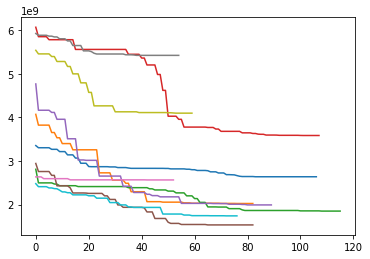

In [39]:
for i in range(len(x_opt_list)):
    opts = []
    for j in range(len(x_opt_list[i].allvecs)):
        opts.append(objective2(x_opt_list[i].allvecs[j]))
    plt.plot(range(len(opts)),opts)

## Coordinate Descent

In [11]:
start_time = time.time()

#for ws in np.linspace(0,163,16):
#	for we in np.linspace(ws+10.866,163,int((163-(ws+10.866))/11)):
#		for wh in np.linspace(0.1,5,10):

wall_init = [40.,60.,1.0]
heights_init = np.ones(8)*2
#x_opt = scipy.optimize.minimize(objective2, heights_init, method='Nelder-Mead', tol = 10.0e5, options = {'disp': True, 'return_all': True})
#print(x_opt) 

heights_temp = heights_init.copy()
heights_min = heights_temp.copy()
cost_temp = objective2(heights_temp)
cost_min = cost_temp
epoch_min_prev = heights_init.copy()
min_store = []


hvals = np.linspace(0,5.0,11)
for epoch in range(8):
    print(epoch)
    for index in range(8):
        heights_temp = heights_min.copy()
        for j, h_val in enumerate(hvals):
            heights_temp[index] = h_val
            cost_temp = objective2(heights_temp)
            if cost_temp < cost_min:
                cost_min = cost_temp
                print("new min")
                heights_min[index] = h_val    
                min_store.append(cost_min)
            print(heights_temp)
            print(heights_min)
    if np.array_equal(epoch_min_prev,heights_min):
        break
    epoch_min_prev = heights_min.copy()
print(heights_min)

       


#if total_cost_new < total_cost:
#	total_cost  = total_cost_new
#	cost_opt 	= np.append(cost_opt,total_cost_new)
#	x_opt	  	= np.concatenate((x_opt,x))

elapsed_time = time.time() - start_time
print("Elapsed Time: ",elapsed_time, "sec")

0
2424580077.742787
0
0
5663704594.237622
[0. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5522176570.324402
[0.5 2.  2.  2.  2.  2.  2.  2. ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
4945995779.357748
[1. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
4032788671.311684
[1.5 2.  2.  2.  2.  2.  2.  2. ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
2424580077.742787
[2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
2414194645.4334245
new min
[2.5 2.  2.  2.  2.  2.  2.  2. ]
[2.5 2.  2.  2.  2.  2.  2.  2. ]
0
2459376812.893998
[3. 2. 2. 2. 2. 2. 2. 2.]
[2.5 2.  2.  2.  2.  2.  2.  2. ]
0
2508588812.893998
[3.5 2.  2.  2.  2.  2.  2.  2. ]
[2.5 2.  2.  2.  2.  2.  2.  2. ]
0
2557800812.893998
[4. 2. 2. 2. 2. 2. 2. 2.]
[2.5 2.  2.  2.  2.  2.  2.  2. ]
0
2607012812.893998
[4.5 2.  2.  2.  2.  2.  2.  2. ]
[2.5 2.  2.  2.  2.  2.  2.  2. ]
0
2656224812.893998
[5. 2. 2. 2. 2. 2. 2. 2.]
[2.5 2.  2.  2.  2.  2.  2.  2. ]
0
5255020348.644816
[2.5 0.  2.  2.  2.  2.  2.  2. ]
[2.5 2.  2.  2.  2.  2.  2.  2. ]
0

1434886968.5884402
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1475667152.3306017
[3.  1.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1524879152.3306017
[3.5 1.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1574091152.3306017
[4.  1.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1623303152.3306017
[4.5 1.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1672515152.3306017
[5.  1.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
4977769455.909796
[2.5 0.  2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
3846791985.84349
[2.5 0.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1899254682.071997
[2.5 1.  2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1434886968.5884402
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1457879627.2649362
[2.5 2.  2.5 1.  1.5 1.  2.  1.5]
[2.5 1.5 2.5 1.  1.5 1.  2.  1.5]
0
1507088100.4023154
[2.5 2

In [21]:
start_time = time.time()

#for ws in np.linspace(0,163,16):
#	for we in np.linspace(ws+10.866,163,int((163-(ws+10.866))/11)):
#		for wh in np.linspace(0.1,5,10):

wall_init = [40.,60.,1.0]
heights_init = np.ones(8)*2
#x_opt = scipy.optimize.minimize(objective2, heights_init, method='Nelder-Mead', tol = 10.0e5, options = {'disp': True, 'return_all': True})
#print(x_opt) 

heights_temp = heights_init.copy()
heights_min = heights_temp.copy()
cost_temp = objective2(heights_temp)
cost_min = cost_temp
epoch_min_prev = heights_init.copy()
min_store = []


hvals = np.linspace(0,5.0,31)
for epoch in range(10):
    print("-------------epoch--------------\n"+str(epoch))
    for index in range(8):
        heights_temp = heights_min.copy()
        for j, h_val in enumerate(hvals):
            heights_temp[index] = h_val
            cost_temp = objective2(heights_temp)
            if cost_temp < cost_min:
                cost_min = cost_temp
                print("new min")
                heights_min[index] = h_val    
                min_store.append(cost_min)
            print(heights_temp)
            print(heights_min)
    if np.array_equal(epoch_min_prev,heights_min):
        break
    epoch_min_prev = heights_min.copy()
print(heights_min)

       


#if total_cost_new < total_cost:
#	total_cost  = total_cost_new
#	cost_opt 	= np.append(cost_opt,total_cost_new)
#	x_opt	  	= np.concatenate((x_opt,x))

elapsed_time = time.time() - start_time
print("Elapsed Time: ",elapsed_time, "sec")

0
2424580077.742787
-------------epoch--------------
0
0
5663704594.237622
[0. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5469534386.122973
[0.16666667 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5385866603.612106
[0.33333333 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5522176570.324402
[0.5 2.  2.  2.  2.  2.  2.  2. ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5542589036.815781
[0.66666667 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5205657696.577372
[0.83333333 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
4945995779.357748
[1. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
4360467186.108885
[1.16666667 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
3942086032.852209
[1.33333333 2.         2.         2.         2.         

2535572332.1081023
[2.16666667 3.33333333 2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2551976332.108102
[2.16666667 3.5        2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2568380332.108102
[2.16666667 3.66666667 2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2584784332.108102
[2.16666667 3.83333333 2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2601188332.108102
[2.16666667 4.         2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2617592332.108102
[2.16666667 4.16666667 2.         2.         2.    

1855158291.9644945
[2.16666667 1.33333333 2.16666667 0.33333333 2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.16666667 2.         2.
 2.         2.        ]
0
1803315697.4081438
new min
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1810729301.805586
[2.16666667 1.33333333 2.16666667 0.66666667 2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1805477097.4422903
[2.16666667 1.33333333 2.16666667 0.83333333 2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1844120143.84791
[2.16666667 1.33333333 2.16666667 1.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1835538563.7038615
[2.16666667 1.33333333 2.16666667 1.16666

1852527697.4081438
[2.16666667 1.33333333 2.16666667 0.5        2.5        2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1868931697.4081435
[2.16666667 1.33333333 2.16666667 0.5        2.66666667 2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1885335697.4081438
[2.16666667 1.33333333 2.16666667 0.5        2.83333333 2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1901739697.4081438
[2.16666667 1.33333333 2.16666667 0.5        3.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1918143697.4081435
[2.16666667 1.33333333 2.16666667 0.5        3.16666667 2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1934547697.4081438
[2.16666667 1.33333333 2.16666667 0.5        3

2221194746.4701924
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 4.66666667
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
2254002746.4701924
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 4.83333333
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
2286810746.4701924
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 5.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 0.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 0.16666667 2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666

1526035075.4545395
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.66666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1544899675.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.83333333]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1582628875.4545395
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1601493475.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.33333333]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1620358075.4545393
[2.16666667 1.33333333 2.16666667 0.5        0

1620748408.7228525
[3.83333333 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1637152408.7228527
[4.         1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1653556408.7228525
[4.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1669960408.7228525
[4.33333333 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1686364408.7228527
[4.5        1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1702768408.7228527
[4.66666667 1.33333333 2.16666667 0.5        0

4720665004.294359
[2.16666667 1.33333333 0.83333333 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
4563787581.214961
[2.16666667 1.33333333 1.         0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
4175954606.216251
[2.16666667 1.33333333 1.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
3530859764.5874796
[2.16666667 1.33333333 1.33333333 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
3266106671.995133
[2.16666667 1.33333333 1.5        0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
3285180033.622145
[2.16666667 1.33333333 1.66666667 0.5        0.8333

1711926872.2449827
[2.16666667 1.33333333 2.16666667 3.         0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1728330872.2449822
[2.16666667 1.33333333 2.16666667 3.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1744734872.2449822
[2.16666667 1.33333333 2.16666667 3.33333333 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1761138872.2449827
[2.16666667 1.33333333 2.16666667 3.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1777542872.2449827
[2.16666667 1.33333333 2.16666667 3.66666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1793946872.2449822
[2.16666667 1.33333333 2.16666667 3.83333333 0

2725272796.6195216
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2263044807.4452405
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.16666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1890655382.238164
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.33333333
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1715284625.1547742
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.5
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1726953601.664991
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.66666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1681526544.4220343
[2.16666667 1.33333333 

1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.16666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.33333333 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.5        1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.66666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0

1796003979.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1814868579.5910172
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.33333333]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1833733179.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.5       ]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1852597779.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.66666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1871462379.5910172
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.83333333]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1890326979.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0

1473524211.5908415
[2.16666667 1.16666667 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1468426134.844557
[2.16666667 1.5        2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1481232290.3423607
[2.16666667 1.66666667 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1493789554.6637642
[2.16666667 1.83333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1509827068.5871072
[2.16666667 2.         2.16666667 0.16666667 0.

1607827046.0653098
[2.16666667 1.33333333 3.33333333 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1624231046.06531
[2.16666667 1.33333333 3.5        0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1640635046.06531
[2.16666667 1.33333333 3.66666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1657039046.06531
[2.16666667 1.33333333 3.83333333 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1673443046.06531
[2.16666667 1.33333333 4.         0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1689847046.06531
[2.16666667 1.33333333 4.16666667 0.16666667 0.83333333 

3314524801.255868
[2.16666667 1.33333333 2.16666667 0.16666667 0.33333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2505545833.167279
[2.16666667 1.33333333 2.16666667 0.16666667 0.5        1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1919002904.0834386
[2.16666667 1.33333333 2.16666667 0.16666667 0.66666667 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1508851139.071423
[2.16666667 1.33333333 2.16666667 0.16666667 1.         1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1520960068.954532
[2.16666667 1.33333333 2.16666667 0.16666667 1.166

1759880599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 2.5
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1792688599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 2.66666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1825496599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 2.83333333
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1858304599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 3.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1891112599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 3.16666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1923920599.4291546
[2.16666667 1.3333333

0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 4.66666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 4.83333333 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 5.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2576218749.1754565
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         0.        ]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2316661708.5355325
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         0.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1821176497.9720047
[2.16666667 1.33333333 2.16666667 0.16666667

In [22]:
print(heights_min)
print(objective2(heights_min))

[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
1460164799.2464008


In [23]:
print(min_store)

[2404344056.3113294, 2397740773.348466, 2371158820.0546913, 2361260370.158409, 1917558563.7038617, 1829938683.4052715, 1803315697.4081438, 1696266746.4701924, 1563764275.4545393, 1553287085.845192, 1472613732.2833352, 1460164799.2464008]


In [17]:
cost_store = []
for array in min_store:
    cost_store.append(objective2(array))

0
1434886968.5884402
0
1434886968.5884402
0
1434886968.5884402
0
1434886968.5884402
0
1434886968.5884402
0
1434886968.5884402
0
1434886968.5884402
0
1434886968.5884402
0
1434886968.5884402


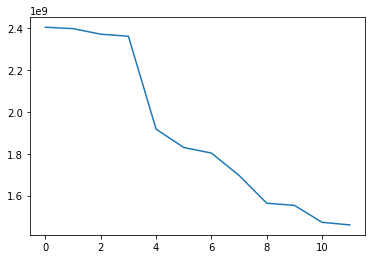

In [25]:
plt.plot(range(len(min_store)),min_store)

#### Random Inputs

In [21]:
NUMINITS = 10
init_list = []
descending_wall_list = []
descending_cost_list = []
x_opt_list = []

plt.figure()
for init_i in range(NUMINITS):

    start_time = time.time()

    #for ws in np.linspace(0,163,16):
    #	for we in np.linspace(ws+10.866,163,int((163-(ws+10.866))/11)):
    #		for wh in np.linspace(0.1,5,10):

    #wall_init = [40.,60.,1.0]
    heights_init = np.random.uniform(low = 0.0, high = 5.0, size = 8)
    #x_opt = scipy.optimize.minimize(objective2, heights_init, method='Nelder-Mead', tol = 10.0e5, options = {'disp': True, 'return_all': True})
    #print(x_opt) 

    heights_temp = heights_init.copy()
    heights_min = heights_temp.copy()
    cost_temp = objective2(heights_temp)
    cost_min = cost_temp
    epoch_min_prev = heights_init.copy()
    min_store = []
    heights_store = []


    hvals = np.linspace(0,5.0,31)
    for epoch in range(10):
        print("-------------epoch--------------\n"+str(epoch))
        for index in range(8):
            heights_temp = heights_min.copy()
            for j, h_val in enumerate(hvals):
                heights_temp[index] = h_val
                cost_temp = objective2(heights_temp)
                if cost_temp < cost_min:
                    cost_min = cost_temp
                    print("new min")
                    heights_min[index] = h_val    
                    min_store.append(cost_min)
                    heights_store.append(heights_min.copy())
                print(heights_temp)
                print(heights_min)
        if np.array_equal(epoch_min_prev,heights_min):
            break
        epoch_min_prev = heights_min.copy()
    print(heights_min)

    plt.plot(range(len(min_store)),min_store)
    


    #if total_cost_new < total_cost:
    #	total_cost  = total_cost_new
    #	cost_opt 	= np.append(cost_opt,total_cost_new)
    #	x_opt	  	= np.concatenate((x_opt,x))

    elapsed_time = time.time() - start_time
    print("Elapsed Time: ",elapsed_time, "sec")

plt.savefig('coordloop.png')

0
2424580077.742787
-------------epoch--------------
0
0
5663704594.237622
[0. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5469534386.122973
[0.16666667 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5385866603.612106
[0.33333333 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5522176570.324402
[0.5 2.  2.  2.  2.  2.  2.  2. ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5542589036.815781
[0.66666667 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
5205657696.577372
[0.83333333 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
4945995779.357748
[1. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
4360467186.108885
[1.16666667 2.         2.         2.         2.         2.
 2.         2.        ]
[2. 2. 2. 2. 2. 2. 2. 2.]
0
3942086032.852209
[1.33333333 2.         2.         2.         2.         

2535572332.1081023
[2.16666667 3.33333333 2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2551976332.108102
[2.16666667 3.5        2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2568380332.108102
[2.16666667 3.66666667 2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2584784332.108102
[2.16666667 3.83333333 2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2601188332.108102
[2.16666667 4.         2.         2.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.         2.         2.         2.
 2.         2.        ]
0
2617592332.108102
[2.16666667 4.16666667 2.         2.         2.    

1855158291.9644945
[2.16666667 1.33333333 2.16666667 0.33333333 2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.16666667 2.         2.
 2.         2.        ]
0
1803315697.4081438
new min
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1810729301.805586
[2.16666667 1.33333333 2.16666667 0.66666667 2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1805477097.4422903
[2.16666667 1.33333333 2.16666667 0.83333333 2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1844120143.84791
[2.16666667 1.33333333 2.16666667 1.         2.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        2.         2.
 2.         2.        ]
0
1835538563.7038615
[2.16666667 1.33333333 2.16666667 1.16666

1852527697.4081438
[2.16666667 1.33333333 2.16666667 0.5        2.5        2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1868931697.4081435
[2.16666667 1.33333333 2.16666667 0.5        2.66666667 2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1885335697.4081438
[2.16666667 1.33333333 2.16666667 0.5        2.83333333 2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1901739697.4081438
[2.16666667 1.33333333 2.16666667 0.5        3.         2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1918143697.4081435
[2.16666667 1.33333333 2.16666667 0.5        3.16666667 2.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 2.
 2.         2.        ]
0
1934547697.4081438
[2.16666667 1.33333333 2.16666667 0.5        3

2221194746.4701924
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 4.66666667
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
2254002746.4701924
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 4.83333333
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
2286810746.4701924
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 5.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 0.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 0.16666667 2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666

1526035075.4545395
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.66666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1544899675.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.83333333]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1563764275.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.        ]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1582628875.4545395
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1601493475.4545393
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         2.33333333]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1620358075.4545393
[2.16666667 1.33333333 2.16666667 0.5        0

1620748408.7228525
[3.83333333 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1637152408.7228527
[4.         1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1653556408.7228525
[4.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1669960408.7228525
[4.33333333 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1686364408.7228527
[4.5        1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
1702768408.7228527
[4.66666667 1.33333333 2.16666667 0.5        0

4720665004.294359
[2.16666667 1.33333333 0.83333333 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
4563787581.214961
[2.16666667 1.33333333 1.         0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
4175954606.216251
[2.16666667 1.33333333 1.16666667 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
3530859764.5874796
[2.16666667 1.33333333 1.33333333 0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
3266106671.995133
[2.16666667 1.33333333 1.5        0.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.5        0.83333333 1.
 2.         1.16666667]
0
3285180033.622145
[2.16666667 1.33333333 1.66666667 0.5        0.8333

1711926872.2449827
[2.16666667 1.33333333 2.16666667 3.         0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1728330872.2449822
[2.16666667 1.33333333 2.16666667 3.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1744734872.2449822
[2.16666667 1.33333333 2.16666667 3.33333333 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1761138872.2449827
[2.16666667 1.33333333 2.16666667 3.5        0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1777542872.2449827
[2.16666667 1.33333333 2.16666667 3.66666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1793946872.2449822
[2.16666667 1.33333333 2.16666667 3.83333333 0

2725272796.6195216
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2263044807.4452405
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.16666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1890655382.238164
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.33333333
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1715284625.1547742
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.5
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1726953601.664991
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 0.66666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1681526544.4220343
[2.16666667 1.33333333 

1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.16666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.33333333 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.5        1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.66666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0

1796003979.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1814868579.5910172
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.33333333]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1833733179.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.5       ]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1852597779.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.66666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1871462379.5910172
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         4.83333333]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1890326979.5910168
[2.16666667 1.33333333 2.16666667 0.16666667 0

1473524211.5908415
[2.16666667 1.16666667 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1468426134.844557
[2.16666667 1.5        2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1481232290.3423607
[2.16666667 1.66666667 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1493789554.6637642
[2.16666667 1.83333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1509827068.5871072
[2.16666667 2.         2.16666667 0.16666667 0.

1607827046.0653098
[2.16666667 1.33333333 3.33333333 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1624231046.06531
[2.16666667 1.33333333 3.5        0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1640635046.06531
[2.16666667 1.33333333 3.66666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1657039046.06531
[2.16666667 1.33333333 3.83333333 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1673443046.06531
[2.16666667 1.33333333 4.         0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1689847046.06531
[2.16666667 1.33333333 4.16666667 0.16666667 0.83333333 

3314524801.255868
[2.16666667 1.33333333 2.16666667 0.16666667 0.33333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2505545833.167279
[2.16666667 1.33333333 2.16666667 0.16666667 0.5        1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1919002904.0834386
[2.16666667 1.33333333 2.16666667 0.16666667 0.66666667 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1508851139.071423
[2.16666667 1.33333333 2.16666667 0.16666667 1.         1.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1520960068.954532
[2.16666667 1.33333333 2.16666667 0.16666667 1.166

1759880599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 2.5
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1792688599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 2.66666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1825496599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 2.83333333
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1858304599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 3.
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1891112599.4291546
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 3.16666667
 2.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1923920599.4291546
[2.16666667 1.3333333

0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 4.66666667 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 4.83333333 1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1460164799.2464008
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 5.         1.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2576218749.1754565
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         0.        ]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
2316661708.5355325
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         0.16666667]
[2.16666667 1.33333333 2.16666667 0.16666667 0.83333333 1.
 2.         1.16666667]
0
1821176497.9720047
[2.16666667 1.33333333 2.16666667 0.16666667

# GP stuff

In [6]:
hrange = np.linspace(0,4.0,100)
costs_list = []
for h in hrange:
    costs_list.append(objective2(np.ones(8)*h))
    


0
5565069925.69983
0
5494109332.80951
0
5465844072.715617
0
5438864918.097705
0
5376923140.63354
0
5308817261.100259
0
5277716994.470485
0
5087335978.99732
0
5053527147.061141
0
4992477525.074153
0
4935607356.943283
0
4900609754.322519
0
4887012047.041897
0
4877056287.102
0
4879226253.911379
0
4839884126.911927
0
4858160631.47768
0
4843299349.489149
0
4967783805.261438
0
4977091816.276852
0
5091065606.041805
0
4973233426.624227
0
5009515406.140753
0
5011371762.802026
0
4901589401.132465
0
4813721579.869692
0
4685248967.778221
0
4733311600.3003645
0
4779237622.289928
0
4618493706.032889
0
4498219318.087076
0
4416681140.927172
0
4361480805.358791
0
4127198640.9964604
0
3890952901.04834
0
3751012329.2779555
0
3822039119.9612226
0
3762764784.0184646
0
3886631428.9157577
0
4012471364.6951227
0
3829992168.8621607
0
3702146737.5817037
0
3578231857.9103413
0
3304338253.9510646
0
2936086770.831454
0
2748641623.912222
0
2728870136.303008
0
2709601738.086775
0
2570607773.053118
0
2508391150.70586

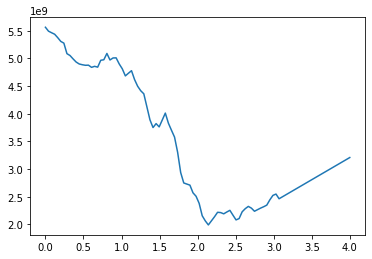

In [7]:
plt.plot(hrange,costs_list)

In [27]:
from mpl_toolkits import mplot3d

0
4887710706.031441
0
4958071559.66013
0
5015631503.376703
0
4997340287.062654
0
4696389927.420527
0
3982957194.5809913
0
3978973583.577642
0
2989904292.5048
0
3051076547.171475
0
2980543860.932104
0
3060662408.353184
0
3069444388.304561
0
3168034633.828572
0
3238764670.2134895
0
3310558127.7494082
0
3383081075.1178293
0
3455604022.4862504
0
3528126969.8546715
0
3600649917.2230926
0
3673172864.5915136
0
4761416698.804417
0
4842459435.588004
0
4894364351.24884
0
4878340828.354595
0
4569609112.934424
0
3849052091.2429647
0
3823984385.2672143
0
2804556581.573012
0
2378592264.5353975
0
2301472614.2431293
0
2406020767.4817986
0
2434743054.4696646
0
2513551055.0318713
0
2565450400.551344
0
2636213754.4359403
0
2708736701.804362
0
2781259649.1727824
0
2853782596.541204
0
2926305543.9096246
0
2998828491.278046
0
4836270871.909359
0
4939830071.985336
0
5006548757.4175
0
4993091206.40559
0
4677776034.5260105
0
3958530590.0020924
0
3932373074.04057
0
2904225700.4653597
0
2529109201.5327163
0
1966

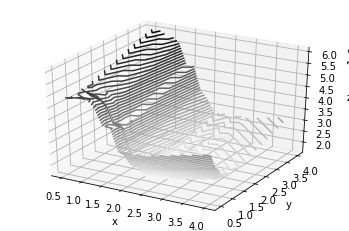

In [30]:


def f(x, y):
    returnmatrix = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            returnmatrix[i,j] = objective2(np.concatenate((np.ones(4)*x[i,j],np.ones(4)*y[i,j])))
    return returnmatrix

x = np.linspace(0.5, 4, 20)
y = np.linspace(0.5, 4, 20)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Text(0.5, 0.92, 'surface')

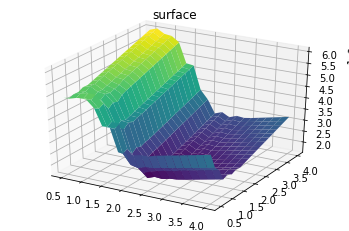

In [31]:
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface')

In [9]:
hrangenew = np.linspace(1,3.0,10)
costs2partarray = np.zeros((10,10))
for i, h1 in enumerate(hrangenew):
    for j, h2 in enumerate(hrangenew):
        costs2partarray[i,j] = objective2(np.concatenate((np.ones(4)*h1,np.ones(4)*h2)))

0
4836656042.531507
0
4772389848.209722
0
4864271868.805255
0
4953159216.063716
0
5115122802.763398
0
5133760154.11712
0
5224528954.11712
0
5315297754.11712
0
5406066554.11712
0
5496835354.11712
0
4516611089.011369
0
4467511260.088655
0
4482904255.544521
0
4708327847.120077
0
4933341665.342777
0
4901100207.076302
0
4991869007.076301
0
5082637807.076301
0
5173406607.076303
0
5264175407.076302
0
3743485242.9280334
0
3695476148.2197647
0
3730235817.0943074
0
3821438980.596878
0
4021706228.8463235
0
3989965604.260226
0
4080734404.2602253
0
4171503204.2602253
0
4262272004.2602262
0
4353040804.260227
0
3600065303.0581284
0
3550944908.396636
0
3588490414.1327105
0
3679308865.2336364
0
3866695815.8522162
0
3835214361.5675797
0
3925983161.567579
0
4016751961.567579
0
4107520761.5675797
0
4198289561.5675797
0
2482256728.000118
0
2430626147.2064195
0
2464333991.329305
0
2555128775.164402
0
2742598163.1779485
0
2711219462.733018
0
2801988262.7330174
0
2892757062.7330174
0
2983525862.7330174
0
3074

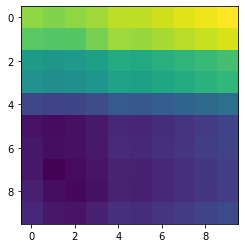

In [10]:
plt.imshow(costs2partarray)

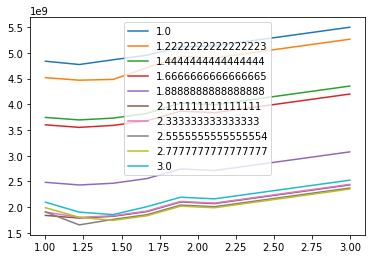

In [21]:
for i in range(10):
    plt.plot(hrangenew,costs2partarray[i,:], label = str(hrangenew[i]))
plt.legend()

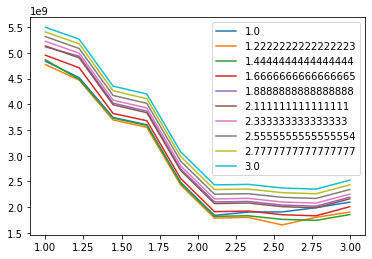

In [24]:
for j in range(10):
    plt.plot(hrangenew,costs2partarray[:,j],label = str(hrangenew[j]))
    
plt.legend()